In [52]:
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import aa598.hw1_helper as hw1_helper


from matplotlib import rc
# rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=False) # set to False if latex is not set up on your computer


## Visualize data

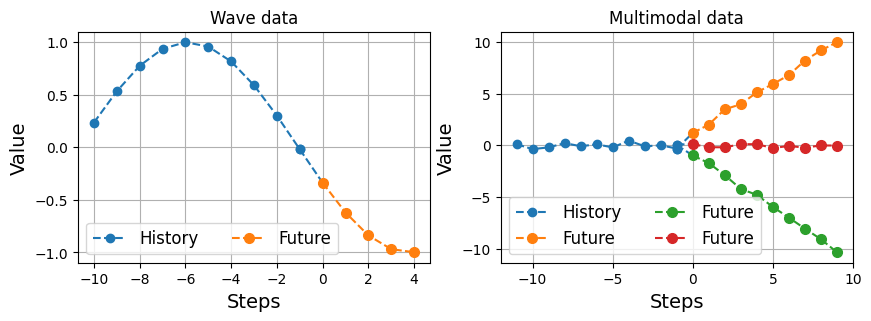

In [53]:
with open("data/hw1/wave_data_train.pickle", 'rb') as handle:
    wave_data = pickle.load(handle)
history = wave_data["history"]
future = wave_data["future"]

index = 1
history_length = history.shape[-1]
future_length = future.shape[-1]
ts_history = np.arange(-history_length,0)
ts_future = np.arange(future_length)

plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.plot(ts_history, history[index], marker='o', linestyle='--', label="History")
plt.plot([-1,0], [history[index][-1], future[index][0]], marker='o', linestyle='--', color="C0")
plt.plot(ts_future, future[index], markersize=7, marker='o', linestyle='--', label="Future")

plt.xlabel('Steps', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=12, ncols=2)
plt.title("Wave data")
plt.grid(True)
# plt.show()

with open("data/hw1/multimodal_data_test.pickle", 'rb') as handle:
    wave_data = pickle.load(handle)
history = wave_data["history"]
future = wave_data["future"]

index = 1
history_length = history.shape[-1]
future_length = future.shape[-1]
ts_history = np.arange(-history_length,0)
ts_future = np.arange(future_length)

plt.subplot(1,2,2)
plt.plot(ts_history, history[index], marker='o', linestyle='--', label="History")
for i in range(3):
    plt.plot([-1,0], [history[i*100 + index][-1], future[i*100 + index][0]], marker='o', linestyle='--', color="C0")
    plt.plot(ts_future, future[i*100 + index], markersize=7, marker='o', linestyle='--', label="Future")

plt.xlabel('Steps', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=12, ncols=2)
plt.title("Multimodal data")
plt.grid(True)
plt.show()


## Regression with sinusoidal trajectories

In this problem, you will learn a regular MLP to regress on sinusoidal data

In [54]:
# feel free to poke around the data
train_data = hw1_helper.TrajectoryData("data/hw1/wave_data_train")
test_data = hw1_helper.TrajectoryData("data/hw1/wave_data_test")

history_length = 10
future_length = 5
input_size = 1  
output_size = 1

print("Train set has %i examples"%len(train_data))
print("Test set has %i examples"%len(test_data))

Train set has 10000 examples
Test set has 500 examples


### Simple MLP predictor

In [55]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
# Define a simple MLP model
class MLP(torch.nn.Module):
    def __init__(self, history_length, future_length, hidden_size=32):
        super(MLP, self).__init__()
        
        # TODO: construct MLP network
        self.model = torch.nn.Sequential(
            torch.nn.Linear(history_length, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, future_length)
        )
        #############################

    def forward(self, x):
        print(x.size())
        return self.model(x)



Using cuda device


In [56]:
hidden_size = 8
history_length = 10
future_length = 5

model = MLP(history_length, future_length, hidden_size)

learning_rate = 0.001
num_epochs = 30
batch_size = 32
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [57]:
model, optimizer = hw1_helper.train(model, optimizer, train_dataloader, criterion, num_epochs)


torch.Size([32, 10])
Epoch [1/30], Step [0/313], Loss: 0.3918
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Epoch [1/30], Step [20/313], Loss: 0.4421
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
Epoch [1/30], Step [40/313], Loss: 0.4155
torch.Size([32

In [58]:
# evaluate on a test set. 
model.eval()
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = model(history)         # Forward pass
    loss = criterion(prediction, future)  # Compute loss
    
# print out test loss
print(f'Test Loss: {loss.item():.4f}')


# Visualize prediction on test data
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_data)-1, step=1, description='Index:')
xlims = [-11, 5]
ylims = [-2,2]
interact(hw1_helper.plot_data_regression, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))



torch.Size([500, 10])
Test Loss: 0.0014


interactive(children=(IntSlider(value=0, description='Index:', max=499), Output()), _dom_classes=('widget-inte…

<function aa598.hw1_helper.plot_data_regression(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

### Simple LSTM predictor

In [59]:

class LSTM(torch.nn.Module):

    def __init__(self, input_dim, output_dim, hidden_dim):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        
        self.device = ("cuda"
                        if torch.cuda.is_available()
                        else "mps"
                        if torch.backends.mps.is_available()
                        else "cpu"
                    )
        
        # HINT: Use Pytorch built-in functions for LSTM and Linear layers.
        # HINT: batch dimension is dim=0
        
        # TODO: Define encoder LSTM.
        self.encoder = torch.nn.LSTM(self.input_dim, self.hidden_dim, batch_first=True)
        ############################
        
        # TODO: Define decoder LSTM
        self.decoder = torch.nn.LSTM(self.output_dim, self.hidden_dim, batch_first=True)
        ############################

        
        #TODO: Define linear project from hidden_dim to output_dim
        self.projection = torch.nn.Linear(self.hidden_dim, self.output_dim)
        ############################



    def forward(self, x, t_max, y=None, prob=1.):
        # Ensure x and y have correct dimensions
        if len(x.shape) == 2:
            x = x.unsqueeze(-1)  # Make it [batch_size, seq_len, input_dim]
        if y is not None and len(y.shape) == 2:
            y = y.unsqueeze(-1)  # Make it [batch_size, t_max, output_dim]
        
        ys = []  # Collect outputs
        
        # Pass through encoder
        _, encoder_hidden = self.encoder(x)

        # Initialize decoder hidden state with encoder's final hidden state
        decoder_hidden = encoder_hidden

        # Initialize the first decoder input with zeros
        batch_size = x.size(0)
        decoder_input = torch.zeros(batch_size, 1, self.output_dim).to(x.device)

        # Unroll decoder
        for t in range(t_max):  # Unroll for t_max steps
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            decoder_output = self.projection(decoder_output)
            
            # Use teacher forcing if applicable
            if y is not None and torch.rand(1).item() < prob:
                decoder_input = y[:, t:t+1, :]  # Use ground truth for teacher forcing
            else:
                decoder_input = decoder_output  # Use prediction from previous step
            
            ys.append(decoder_output)  # Collect prediction

        # Concatenate along time dimension
        return torch.cat(ys, dim=1)  # [batch_size, t_max, output_dim]

In [60]:
hidden_size = 4
future_length = 5
input_size = 1
output_size = 1

model = LSTM(input_size, output_size, hidden_size)

learning_rate = 0.001
num_epochs = 10
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
prob = 0.

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()


def prob_schedule(i):
    return 1 - jax.nn.sigmoid(20 * (i - 0.5)).item()



In [61]:
# we use a slightly different training loop to account for teacher forcing
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    prob = prob_schedule((epoch + 1)/num_epochs)
    for batch_idx, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()        # Zero the gradients
        output = model(data, future_length, target, prob)         # Forward pass
        loss = criterion(output.squeeze(-1), target)  # Compute loss
        loss.backward()              # Backpropagation
        optimizer.step()             # Update weights

        running_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    print(f'Epoch {epoch+1} completed with average loss: {running_loss/len(train_dataloader):.4f}')

print("Training finished!")


Epoch [1/10], Step [0/313], Loss: 0.5022
Epoch [1/10], Step [100/313], Loss: 0.3343
Epoch [1/10], Step [200/313], Loss: 0.2056
Epoch [1/10], Step [300/313], Loss: 0.1274
Epoch 1 completed with average loss: 0.3044
Epoch [2/10], Step [0/313], Loss: 0.1039
Epoch [2/10], Step [100/313], Loss: 0.0488
Epoch [2/10], Step [200/313], Loss: 0.0387
Epoch [2/10], Step [300/313], Loss: 0.0254
Epoch 2 completed with average loss: 0.0546
Epoch [3/10], Step [0/313], Loss: 0.0265
Epoch [3/10], Step [100/313], Loss: 0.0174
Epoch [3/10], Step [200/313], Loss: 0.0141
Epoch [3/10], Step [300/313], Loss: 0.0134
Epoch 3 completed with average loss: 0.0208
Epoch [4/10], Step [0/313], Loss: 0.0210
Epoch [4/10], Step [100/313], Loss: 0.0103
Epoch [4/10], Step [200/313], Loss: 0.0106
Epoch [4/10], Step [300/313], Loss: 0.0054
Epoch 4 completed with average loss: 0.0120
Epoch [5/10], Step [0/313], Loss: 0.0294
Epoch [5/10], Step [100/313], Loss: 0.0082
Epoch [5/10], Step [200/313], Loss: 0.0166
Epoch [5/10], Ste

Test Loss: 25.7162


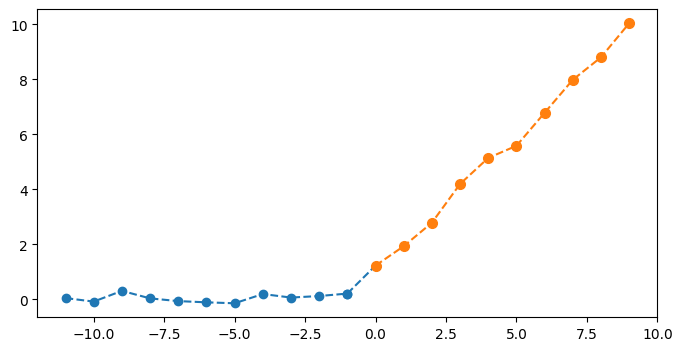

interactive(children=(IntSlider(value=0, description='Index:', max=299), Output()), _dom_classes=('widget-inte…

<function aa598.hw1_helper.plot_data_regression(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

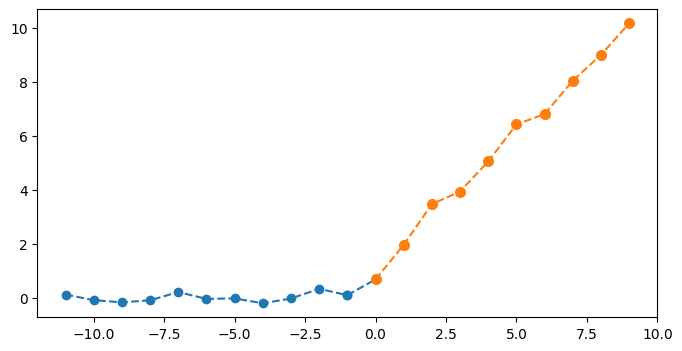

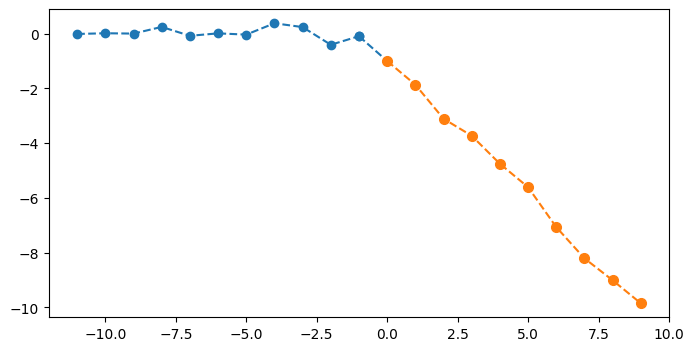

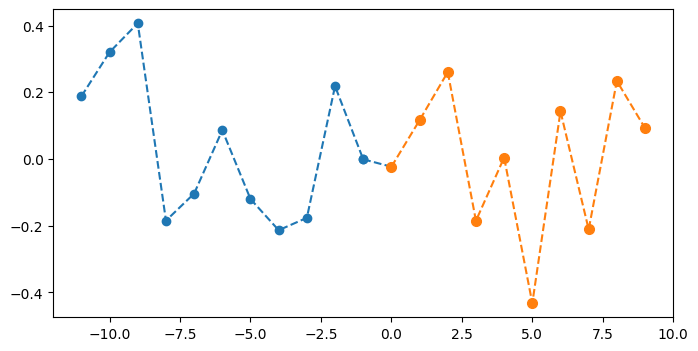

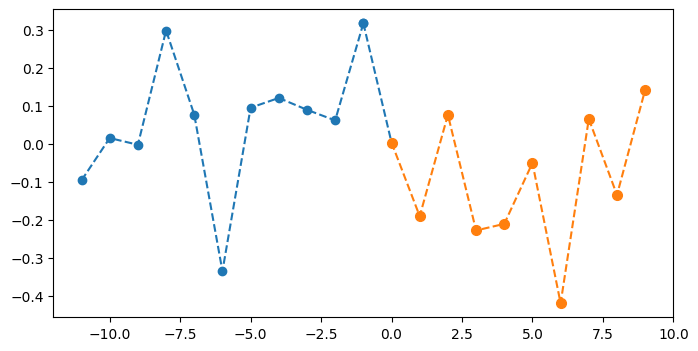

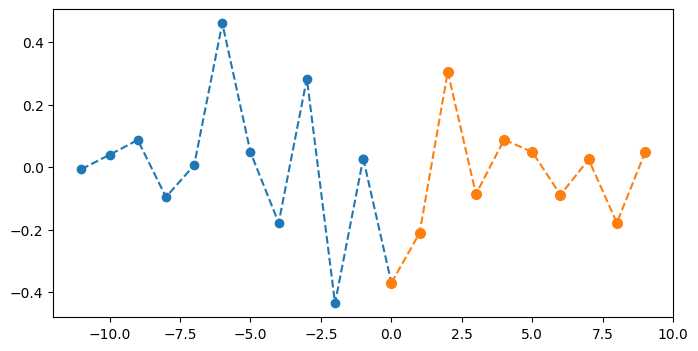

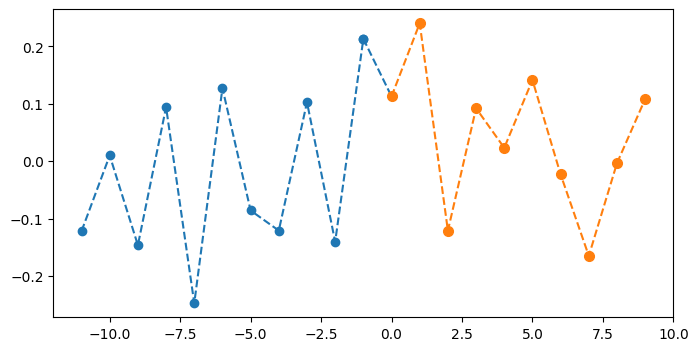

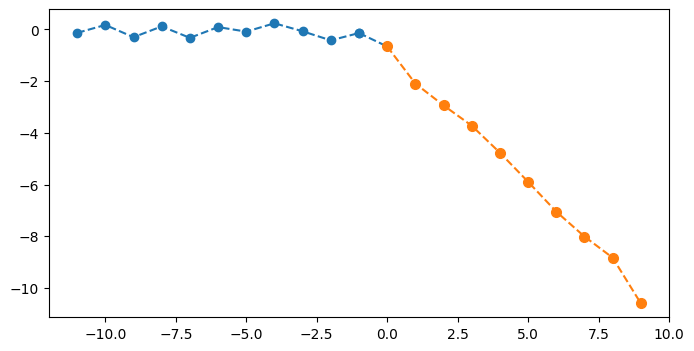

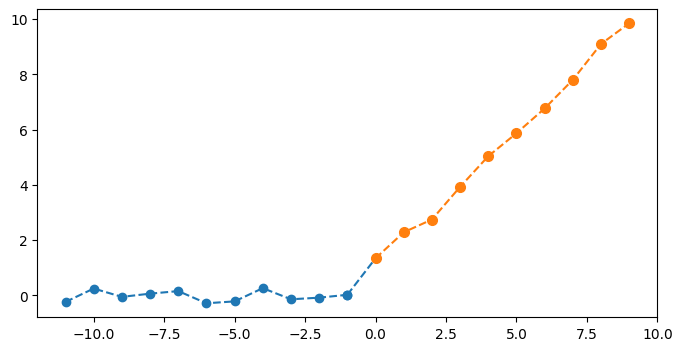

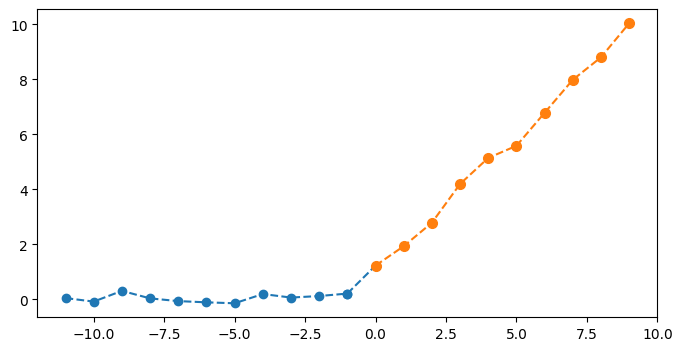

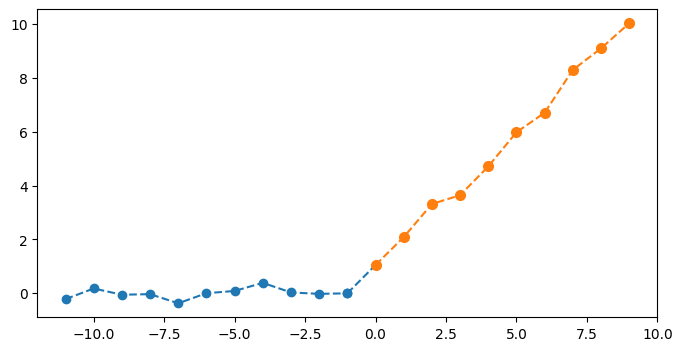

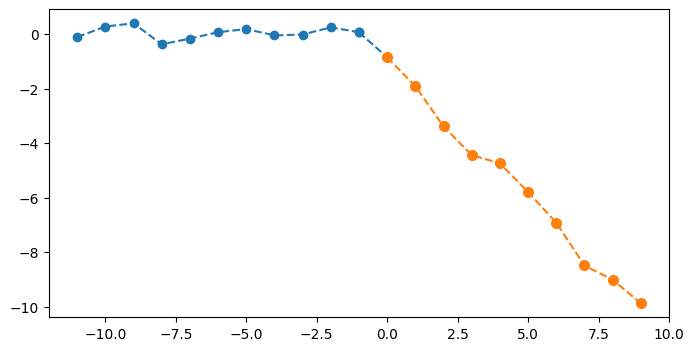

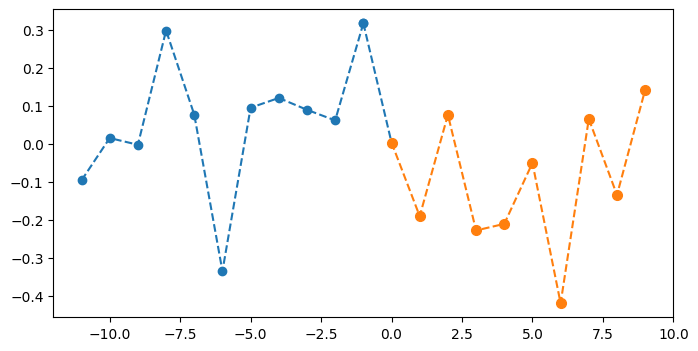

In [84]:
# evaluate on a test set. 
model.eval()
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = model(history, future_length)         # Forward pass
    loss = criterion(prediction.squeeze(-1), future)  # Compute loss
    
# print out test loss
print(f'Test Loss: {loss.item():.4f}')


# try with different prediction horizons
prediction_horizon = 20
prediction = model(history, prediction_horizon)


# Visualize prediction on test data
test_dataloader = list(DataLoader(test_data, batch_size=1, shuffle=False))
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_dataloader)-1, step=1, description='Index:')
xlims = [-11, prediction_horizon + 2]
ylims = [-5,5]
interact(hw1_helper.plot_data_regression, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))



## Regression on multimodal data

Now we repeat the same steps but with data where the future has multimodal outcome. 

In [63]:
# load multimodal data
train_data = hw1_helper.TrajectoryData("data/hw1/multimodal_data_train")
test_data = hw1_helper.TrajectoryData("data/hw1/multimodal_data_test")

history_length = 11
future_length = 10
input_size = 1
output_size = 1

print("Train set has %i examples"%len(train_data))
print("Test set has %i examples"%len(test_data))

Train set has 15000 examples
Test set has 300 examples


### Simple MLP predictor (multimodal data)

In [64]:

hidden_size = 32
# You should be able to use your MLP class
model = MLP(history_length, future_length, hidden_size)

learning_rate = 0.001
num_epochs = 10
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

In [65]:
model, optimizer = hw1_helper.train(model, optimizer, train_dataloader, criterion, num_epochs)

torch.Size([32, 11])
Epoch [1/10], Step [0/469], Loss: 24.0609
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
Epoch [1/10], Step [20/469], Loss: 31.4404
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
Epoch [1/10], Step [40/469], Loss: 21.7600
torch.Size(

In [66]:
# evaluate on a test set. 
model.eval()
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = model(history)         # Forward pass
    loss = criterion(prediction, future)  # Compute loss
    
# print out test loss
print(f'Test Loss: {loss.item():.4f}')


# Visualize prediction on test data
test_dataloader = list(DataLoader(test_data, batch_size=1, shuffle=False))
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_dataloader)-1, step=1, description='Index:')
xlims = [-11, 10]
ylims = [-12, 12]
interact(hw1_helper.plot_data_regression, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))



torch.Size([300, 11])
Test Loss: 25.8615


interactive(children=(IntSlider(value=0, description='Index:', max=299), Output()), _dom_classes=('widget-inte…

<function aa598.hw1_helper.plot_data_regression(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

### Simple LSTM predictor (multimodal data)

In [67]:
hidden_size = 4
# You should be able to use your LSTM class
model = LSTM(input_size, output_size, hidden_size)

learning_rate = 0.001
num_epochs = 10
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()


In [68]:
# we use a slightly different training loop to account for teacher forcing
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()        # Zero the gradients
        output = model(data, future_length, target, prob)         # Forward pass
        loss = criterion(output.squeeze(-1), target)  # Compute loss
        loss.backward()              # Backpropagation
        optimizer.step()             # Update weights

        running_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    print(f'Epoch {epoch+1} completed with average loss: {running_loss/len(train_dataloader):.4f}')

print("Training finished!")


Epoch [1/10], Step [0/469], Loss: 26.9058
Epoch [1/10], Step [100/469], Loss: 27.3090
Epoch [1/10], Step [200/469], Loss: 24.0715
Epoch [1/10], Step [300/469], Loss: 24.2020
Epoch [1/10], Step [400/469], Loss: 23.0301
Epoch 1 completed with average loss: 25.7467
Epoch [2/10], Step [0/469], Loss: 27.6759
Epoch [2/10], Step [100/469], Loss: 26.8589
Epoch [2/10], Step [200/469], Loss: 26.3416
Epoch [2/10], Step [300/469], Loss: 18.0882
Epoch [2/10], Step [400/469], Loss: 26.4964
Epoch 2 completed with average loss: 25.7072
Epoch [3/10], Step [0/469], Loss: 26.2576
Epoch [3/10], Step [100/469], Loss: 28.8979
Epoch [3/10], Step [200/469], Loss: 29.0638
Epoch [3/10], Step [300/469], Loss: 23.9585
Epoch [3/10], Step [400/469], Loss: 27.6386
Epoch 3 completed with average loss: 25.7079
Epoch [4/10], Step [0/469], Loss: 24.0131
Epoch [4/10], Step [100/469], Loss: 28.8987
Epoch [4/10], Step [200/469], Loss: 19.1523
Epoch [4/10], Step [300/469], Loss: 22.7414
Epoch [4/10], Step [400/469], Loss: 2

Test Loss: 25.7162


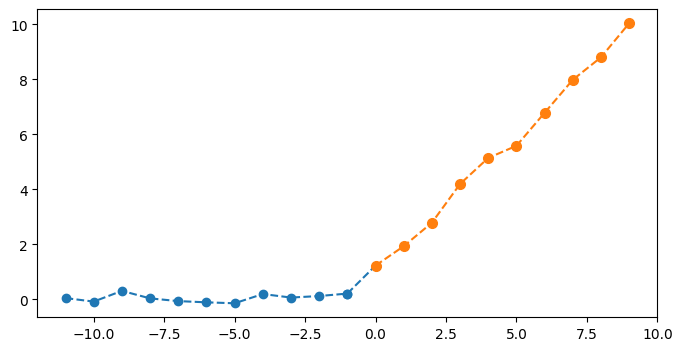

interactive(children=(IntSlider(value=0, description='Index:', max=299), Output()), _dom_classes=('widget-inte…

<function aa598.hw1_helper.plot_data_regression(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

In [69]:
# evaluate on a test set. 
model.eval()
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = model(history, future_length)         # Forward pass
    loss = criterion(prediction.squeeze(-1), future)  # Compute loss
    
# print out test loss
print(f'Test Loss: {loss.item():.4f}')


# TODO: try with different prediction horizons
prediction_horizon = future_length
prediction = model(history, prediction_horizon)


# Visualize prediction on test data
test_dataloader = list(DataLoader(test_data, batch_size=1, shuffle=False))
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_dataloader)-1, step=1, description='Index:')

xlims = [-11, prediction_horizon + 2]
ylims = [-12, 12]

interact(hw1_helper.plot_data_regression, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))



## Consider CVAEs

First, define the encoder and decoder. We will consider some simple MLP encoders. Generally, for trajectory data, it's typically more common to use RNNs or transformers, but since we are considering a small toy problem, we just consider MLP for now since it's simpler.


In [70]:

# some simple MLP encoders. For trajectory data, it's typically more common to use RNNs or transformers
class MLPEncoder(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=32):
        super(MLPEncoder, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        # TODO: Construct an MLP encoder
        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim, self.hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(self.hidden_dim, self.hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(self.hidden_dim, self.output_dim)
        )
        ############################

    def forward(self, x):
        return self.model(x)
    
    
class MLPDecoder(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=32):
        super(MLPDecoder, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        
        # TODO: Construct an MLP encoder
        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim, self.hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(self.hidden_dim, self.hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(self.hidden_dim, self.output_dim),
        )
        ############################
    
    def forward(self, x):
        return self.model(x)


# Some helper functions
def repeat_n(ten, n):
    return torch.stack([ten] * n, dim=0)

def beta_schedule(i):
    return jax.nn.sigmoid(20 * (i - 0.5)).item()


In [71]:
train_data = hw1_helper.TrajectoryData("data/hw1/multimodal_data_train")
test_data = hw1_helper.TrajectoryData("data/hw1/multimodal_data_test")

history_length = 11
future_length = 10
input_size = 1
output_size = 1

print("Train set has %i examples"%len(train_data))
print("Test set has %i examples"%len(test_data))

Train set has 15000 examples
Test set has 300 examples


### Continuous CVAE

In [72]:
class ContinuousCVAE(torch.nn.Module):
    def __init__(self, latent_dim, importance, decoder, prior, hidden_dim, fututre_length):
        '''
        latent_dim: dimension of the continuous latent space
        importance: network to encode the importance weight
        decoder: network to decode the output
        prior: network to encode the prior        
        '''
        
        super(ContinuousCVAE, self).__init__()
        self.latent_dim = latent_dim
        self.importance = importance
        self.decoder = decoder
        self.prior = prior
        self.training = True

        
        # TODO: Linear layers to project encoder/decoder to mean and logvar
        self.mean_projection_encoder = torch.nn.Linear(hidden_dim, latent_dim)
        self.logvar_projection_encoder = torch.nn.Linear(hidden_dim, latent_dim)
        self.mean_projection_decoder = torch.nn.Linear(future_length, future_length)
        self.logvar_projection_decoder = torch.nn.Linear(future_length, future_length)
        ############################

        
    def encode_importance(self, x, y):
        '''Computes mean and log(covariance) of q(z|x,y), assumes normal distribution'''
        
        # TODO: compute z_mu and z_logvar of q(z|x,y)
        z = self.importance(torch.cat([x, y], dim=-1))
        z_mu = self.mean_projection_encoder(z)
        z_logvar = self.logvar_projection_encoder(z)
        ############################
        
        return z_mu, z_logvar
    
    
    def encode_prior(self, x):
        '''Computes mean and log(covariance) of p(z|x), assumes normal distribution'''
        
        # TODO: compute z_mu and z_logvar of p(z|x)
        z_ = self.prior(x)
        z_mu = self.mean_projection_encoder(z_)
        z_logvar = self.mean_projection_encoder(z_)
        ############################
        
        return z_mu, z_logvar
    
    
    def reparameterize(self, mu, logvar, n=1):
        '''samples from a normal distributions parameterized by mu and logvar. Uses PyTorch built-in reparameratization trick'''
        
        prob = torch.distributions.MultivariateNormal(loc=mu, covariance_matrix=torch.diag_embed(torch.exp(logvar)))
        
        return prob.rsample((n,))
    
    
    def decode(self, x, z):
        '''Computes mean and log(covariance) of p(y|x,z), assumes normal distribution'''
        
        # TODO: compute y_mu and y_logvar of p(y|x,z)
        y = self.decoder(torch.cat([x, z], dim=-1))
        y_mu = self.mean_projection_decoder(y)
        y_logvar = self.logvar_projection_decoder(y)
        ############################
        
        return y_mu, y_logvar

    
    def forward(self, x, y, n=1):
        '''forward pass of the cvae model'''
        
        #  get p(z|x,(y))
        if self.training:
            z_mu, z_logvar = self.encode_importance(x, y)
        else:
            z_mu, z_logvar = self.encode_prior(x)
        # sample from p(z|x,(y)) n times
        z = self.reparameterize(z_mu, z_logvar, n)
        # get p(y|x,z)
        y_mu, y_logvar  = self.decode(repeat_n(x, n), z)     
           
        return z_mu, z_logvar, y_mu, y_logvar
    

    
    def sample(self, x, num_samples=8, num_latent_samples=8):
        '''samples from p(y|x,z) where z~p(z|x). Need to specify the number z and y samples to draw'''
        
        _, _, y_mu, y_logvar = self.forward(x, None, num_latent_samples)

        return self.reparameterize(y_mu, y_logvar, num_samples)

    
    
    def elbo(self, x, y, z_samples=1, beta=1.):
        '''Compute ELBO for CVAE with continuous latent space. Optional: beta term that weigh kl divergence term'''
        
        q_mu, q_logvar, y_mu, y_logvar = self(x, y, z_samples) # get parameters for q(z|x,y) and p(y|x,z) where z~q(z|x,y)
        p_mu, p_logvar = self.encode_prior(x) # get parameters for p(z|x)
        
        # construct the distributions
        y_prob = torch.distributions.MultivariateNormal(loc=y_mu, covariance_matrix=torch.diag_embed(torch.exp(y_logvar)))  # p(y|x, z)
        q = torch.distributions.MultivariateNormal(loc=q_mu, covariance_matrix=torch.diag_embed(torch.exp(q_logvar)))  # q(z|x,y)
        p = torch.distributions.MultivariateNormal(loc=p_mu, covariance_matrix=torch.diag_embed(torch.exp(p_logvar)))  # p(z|x)
        
        loglikelihood = -y_prob.log_prob(repeat_n(y, z_samples)).mean() # log likelihood of data 
        kl_div = torch.distributions.kl.kl_divergence(q, p).mean()  # q_z * (log(q_z) - log(p_z))
        
        return loglikelihood + beta * kl_div
        


      

In [73]:
# continuous cvae
# network parameters
latent_dim = 1 # size of latent space
history_length = 11
future_length = 10
hidden_dim = 8
enc_dim = 8
dec_dim = 8

encoder = MLPEncoder(history_length + future_length, hidden_dim, enc_dim)
prior = MLPEncoder(history_length, hidden_dim, enc_dim)
decoder = MLPDecoder(latent_dim+history_length, future_length, dec_dim)

cvae = ContinuousCVAE(latent_dim, encoder, decoder, prior, hidden_dim, future_length)

num_epochs = 10
learning_rate = 1E-3
optimizer = torch.optim.Adam(cvae.parameters(), lr=learning_rate)


batch_size = 8
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)



In [74]:
# train model
z_samples = 16
cvae.train()

for epoch in range(num_epochs):
    running_loss = 0
    beta = beta_schedule((epoch + 1)/ num_epochs) # we slowly increase the weighting on the KL divergence, following https://openreview.net/forum?id=Sy2fzU9gl
    for batch_idx, (history, future) in enumerate(train_dataloader):
        # print(history.size(), "\t", future.size())
        q_mu, q_logvar, y_mu, y_logvar = cvae(history, future)
        p_mu, p_logvar = cvae.encode_prior(history)
        optimizer.zero_grad()
        loss = cvae.elbo(history, future, z_samples, beta)
        loss.backward()
        running_loss += loss.detach().cpu().numpy()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    print(f'======= Epoch {epoch+1} completed with average loss: {running_loss/len(train_dataloader):.4f} =======')

print("Training finished!")

Epoch [1/10], Step [0/1875], Loss: 140.7018
Epoch [1/10], Step [100/1875], Loss: 42.0796
Epoch [1/10], Step [200/1875], Loss: 25.6458
Epoch [1/10], Step [300/1875], Loss: 25.1485
Epoch [1/10], Step [400/1875], Loss: 25.0453
Epoch [1/10], Step [500/1875], Loss: 24.6456
Epoch [1/10], Step [600/1875], Loss: 19.1320
Epoch [1/10], Step [700/1875], Loss: 21.2529
Epoch [1/10], Step [800/1875], Loss: 21.9044
Epoch [1/10], Step [900/1875], Loss: 14.2431
Epoch [1/10], Step [1000/1875], Loss: 17.9927
Epoch [1/10], Step [1100/1875], Loss: 17.0246
Epoch [1/10], Step [1200/1875], Loss: 17.8180
Epoch [1/10], Step [1300/1875], Loss: 13.7347
Epoch [1/10], Step [1400/1875], Loss: 21.8291
Epoch [1/10], Step [1500/1875], Loss: 16.9675
Epoch [1/10], Step [1600/1875], Loss: 17.3467
Epoch [1/10], Step [1700/1875], Loss: 25.7991
Epoch [1/10], Step [1800/1875], Loss: 5.7478
======= Epoch 1 completed with average loss: 25.0627 =======
Epoch [2/10], Step [0/1875], Loss: 17.5020
Epoch [2/10], Step [100/1875], Los

In [75]:
# Visualize prediction on test data

cvae.eval()

num_samples = 8
num_latent_samples = 8

test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = cvae.sample(history, num_samples, num_latent_samples)
    
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_data)-1, step=1, description='Index:')
xlims = [-12, 10]
ylims = [-12, 12]
interact(hw1_helper.plot_data_generative, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))


interactive(children=(IntSlider(value=0, description='Index:', max=299), Output()), _dom_classes=('widget-inte…

<function aa598.hw1_helper.plot_data_generative(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

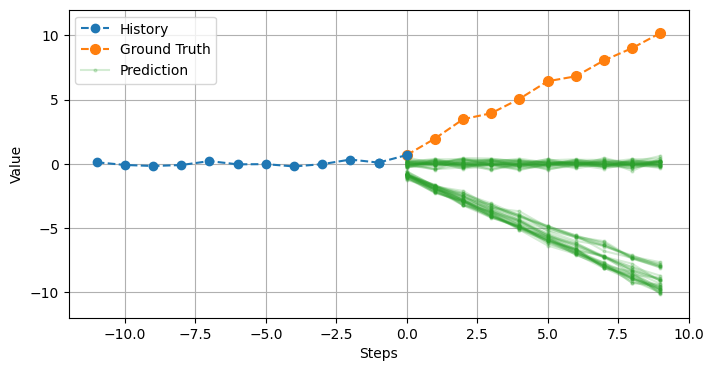

In [76]:
index = 5 # choose an index you want to plot
hw1_helper.plot_data_generative(history=history, future=future, prediction=prediction, index=index, xlims=xlims, ylims=ylims)


### Discrete CVAE

In [77]:
class DiscreteCVAE(torch.nn.Module):
    def __init__(self, latent_dim, importance, decoder, prior, num_categories):
        '''
        latent_dim: dimension of the continuous latent space
        importance: network to encode the importance weight
        decoder: network to decode the output
        prior: network to encode the prior  
        num_categories: number of categories per latent dimension 
        '''
        
        super(DiscreteCVAE, self).__init__()
        self.latent_dim = latent_dim
        self.importance = importance
        self.decoder = decoder
        self.prior = prior
        
        self.logits_projection_encoder = torch.nn.Linear(importance.output_dim, latent_dim * num_categories)
        self.mean_projection_decoder = torch.nn.Linear(decoder.output_dim, decoder.output_dim)
        self.logvar_projection_decoder = torch.nn.Linear(decoder.output_dim, decoder.output_dim)
        self.num_categories = num_categories
        
        # Gumbel-softmax reparameterization
        self.gumbel_temperature = 0.1
        
    def encode_importance(self, x, y):
        '''Computes logits of q(z|x,y), assumes one-hot categorical'''
        xy = torch.cat([x, y], dim=-1)
        h = self.importance(xy)
        z_logits = self.logits_projection_encoder(h).reshape(-1, self.latent_dim, self.num_categories)      
        return z_logits
    
    
    def encode_prior(self, x):
        '''Computes logits of p(z|x), assumes one-hot categorical'''
        h = self.prior(x)
        z_logits = self.logits_projection_encoder(h).reshape(-1, self.latent_dim, self.num_categories)
        
        return z_logits


    def reparameterize(self, logits):
        '''Sample latent variables using one-hot categorical distributions. Uses gumbel-softmax trick. Pytorch has a bulit-in function for this.'''
        
        return F.gumbel_softmax(logits, tau=self.gumbel_temperature, hard=True) 
        
        
    def decode(self, x, z):
        '''Computes mean and log(covariance) of p(y|x,z), assumes normal distribution'''
        xz = torch.cat([x, z], dim=-1)
        g = self.decoder(xz)
        y_mu = self.mean_projection_decoder(g)
        y_logvar = torch.clip(self.logvar_projection_decoder(g), min=-10, max=1)
        
        return y_mu, y_logvar


    def forward(self, x, y, n=1):
        '''forward pass of the cvae model'''
        #  get p(z|x,(y)) and samples from it n times
        if self.training:
            logits = self.encode_importance(x, y) # [bs, latent_dim, num_categories]
            z = self.reparameterize(repeat_n(logits, n)) # [n, bs, latent_dim, num_categories]
        else:
            logits = self.encode_prior(x) # [bs, latent_dim, num_categories]
            z = torch.distributions.OneHotCategorical(logits=logits).sample((n,)) # [n, bs, latent_dim, num_categories]
        z_flatten = z.view(n, -1, self.latent_dim * self.num_categories)  # reshapes to [n, bs, latent_dim * num_categories]
        # get p(y|x,z)
        y_mu, y_logvar  = self.decode(repeat_n(x, n), z_flatten) 

        return logits, y_mu, y_logvar
    
    
    def sample(self, x, num_samples=8, num_latent_samples=8):
        '''samples from p(y|x,z) where z~p(z|x). Need to specify the number z and y samples to draw'''
        _, y_mu, y_logvar = self.forward(x, None, num_latent_samples)

        return  torch.distributions.MultivariateNormal(loc=y_mu, covariance_matrix=torch.diag_embed(torch.exp(y_logvar))).rsample((num_samples,))
        
        
    def elbo(self, x, y, z_samples=1, beta=1.):
        '''Compute ELBO for CVAE with discrete latent space. Optional: beta term that weigh kl divergence term'''

        logits, y_mu, y_logvar = self.forward(x, y, z_samples)
        prior_logits = cvae.encode_prior(x)
        
        y_prob = torch.distributions.MultivariateNormal(loc=y_mu, covariance_matrix=torch.diag_embed(torch.exp(y_logvar)))  # p(y|x, z)
        
        q_z = F.softmax(logits, dim=-1)  # q(z|x,y)
        log_p_z = F.log_softmax(prior_logits, dim=-1)  # log(p(z|x))
        
        loglikelihood = -y_prob.log_prob(repeat_n(y, z_samples)).mean()
        kl_div = torch.nn.KLDivLoss(reduction="batchmean")(log_p_z, q_z)
        
        return loglikelihood + beta * kl_div
      

        


In [78]:
# discrete CVAE

history_length = 11
future_length = 10
hidden_dim = 8
enc_dim = 8
dec_dim = 8

latent_dim = 2
num_categories = 3

encoder = MLPEncoder(history_length + future_length, hidden_dim, enc_dim)
prior = MLPEncoder(history_length, hidden_dim, enc_dim)
decoder = MLPDecoder(latent_dim * num_categories + history_length, future_length, dec_dim)

cvae = DiscreteCVAE(latent_dim, encoder, decoder, prior, num_categories)

learning_rate = 1E-3
optimizer = torch.optim.Adam(cvae.parameters(), lr=learning_rate, weight_decay=1E-2)

batch_size = 8
num_epochs = 10
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [79]:
# train model
cvae.train()
num_latent_samples = 8
for epoch in range(num_epochs):
    running_loss = 0
    for batch_idx, (history, future) in enumerate(train_dataloader):
        beta = beta_schedule((epoch+1) / num_epochs) # we slowly increase the weighting on the KL divergence, following https://openreview.net/forum?id=Sy2fzU9gl
        optimizer.zero_grad()
        loss = cvae.elbo(history, future, num_latent_samples, beta)
        loss.backward()
        running_loss += loss.detach().cpu().numpy()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    print(f'======= Epoch {epoch+1} completed with average loss: {running_loss/len(train_dataloader):.4f} =======')

print("Training finished!")

Epoch [1/10], Step [0/1875], Loss: 130.0520
Epoch [1/10], Step [100/1875], Loss: 60.0702
Epoch [1/10], Step [200/1875], Loss: 40.2761
Epoch [1/10], Step [300/1875], Loss: 76.1566
Epoch [1/10], Step [400/1875], Loss: 51.1542
Epoch [1/10], Step [500/1875], Loss: 56.4240
Epoch [1/10], Step [600/1875], Loss: 47.7060
Epoch [1/10], Step [700/1875], Loss: 75.9391
Epoch [1/10], Step [800/1875], Loss: 75.1512
Epoch [1/10], Step [900/1875], Loss: 63.7563
Epoch [1/10], Step [1000/1875], Loss: 41.6045
Epoch [1/10], Step [1100/1875], Loss: 41.4216
Epoch [1/10], Step [1200/1875], Loss: 19.8589
Epoch [1/10], Step [1300/1875], Loss: 73.9799
Epoch [1/10], Step [1400/1875], Loss: 51.2325
Epoch [1/10], Step [1500/1875], Loss: 74.4274
Epoch [1/10], Step [1600/1875], Loss: 63.2222
Epoch [1/10], Step [1700/1875], Loss: 54.7061
Epoch [1/10], Step [1800/1875], Loss: 42.2935
======= Epoch 1 completed with average loss: 60.8649 =======
Epoch [2/10], Step [0/1875], Loss: 52.1982
Epoch [2/10], Step [100/1875], Lo

In [80]:
# Visualize prediction on test data

cvae.eval()
num_latent_samples = 32
num_samples = 1

test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = cvae.sample(history, num_samples, num_latent_samples)
    
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_data)-1, step=1, description='Index:')
xlims = [-12, 10]
ylims = [-12, 12]
interact(hw1_helper.plot_data_generative, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))


interactive(children=(IntSlider(value=0, description='Index:', max=299), Output()), _dom_classes=('widget-inte…

<function aa598.hw1_helper.plot_data_generative(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

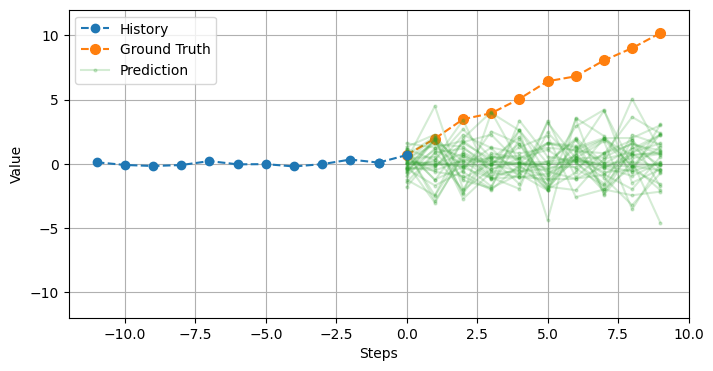

In [81]:
index = 5 # choose an index you want to plot
hw1_helper.plot_data_generative(history=history, future=future, prediction=prediction, index=index, xlims=xlims, ylims=ylims)
